# Vanilla GAN

In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Training Params
num_steps = 70000
batch_size = 128
learning_rate = 0.0002

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # Noise data points

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# Store layers weight & bias
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}

/home/isaac/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
# Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
# Discriminator Network Variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

Step 1: Generator Loss: 1.026712, Discriminator Loss: 1.027338
Step 2000: Generator Loss: 4.559890, Discriminator Loss: 0.036063
Step 4000: Generator Loss: 4.090306, Discriminator Loss: 0.081716
Step 6000: Generator Loss: 3.751032, Discriminator Loss: 0.118809
Step 8000: Generator Loss: 3.596972, Discriminator Loss: 0.136555
Step 10000: Generator Loss: 3.732663, Discriminator Loss: 0.154409
Step 12000: Generator Loss: 4.056768, Discriminator Loss: 0.226251
Step 14000: Generator Loss: 3.790775, Discriminator Loss: 0.192726
Step 16000: Generator Loss: 3.352551, Discriminator Loss: 0.313929
Step 18000: Generator Loss: 3.399351, Discriminator Loss: 0.310653
Step 20000: Generator Loss: 3.192926, Discriminator Loss: 0.465496
Step 22000: Generator Loss: 3.127459, Discriminator Loss: 0.408807
Step 24000: Generator Loss: 3.081844, Discriminator Loss: 0.304744
Step 26000: Generator Loss: 3.703511, Discriminator Loss: 0.369610
Step 28000: Generator Loss: 3.290560, Discriminator Loss: 0.267098
Ste

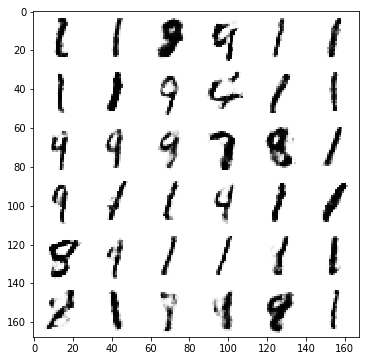

In [5]:
with tf.Session() as sess:
    # Run the initializer
    sess.run(tf.global_variables_initializer())
    
    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)
        # Generate noise to feed to the generator
        z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

        # Train
        feed_dict = {disc_input: batch_x, gen_input: z}
        _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
        if i % 2000 == 0 or i == 1:
            print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
            
    # Testing
    # Generate images from noise, using the generator network.
    n = 6
    canvas = np.empty((28 * n, 28 * n))
    for i in range(n):
        # Noise input.
        z = np.random.uniform(-1., 1., size=[n, noise_dim])
        # Generate image from noise.
        g = sess.run(gen_sample, feed_dict={gen_input: z})
        # Reverse colours for better display
        g = -1 * (g - 1)
        for j in range(n):
            # Draw the generated digits
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

    plt.figure(figsize=(n, n))
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()

# DCGAN

In [9]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.reset_default_graph()

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [10]:
# Training Params
num_steps = 10000
batch_size = 128
lr_generator = 0.002
lr_discriminator = 0.002

# Network Params
image_dim = 784 # 28*28 pixels * 1 channel
noise_dim = 100 # Noise data points

In [11]:
# Build Networks
# Network Inputs
noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
# A boolean to indicate batch normalization if it is training or inference time
is_training = tf.placeholder(tf.bool)

#LeakyReLU activation
def leakyrelu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        # TensorFlow Layers automatically create variables and calculate their
        # shape, based on the input.
        x = tf.layers.dense(x, units=7 * 7 * 128)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        # Deconvolution, image shape: (batch, 14, 14, 64)
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        # Deconvolution, image shape: (batch, 28, 28, 1)
        x = tf.layers.conv2d_transpose(x, 1, 5, strides=2, padding='same')
        # Apply tanh for better stability - clip values to [-1, 1].
        x = tf.nn.tanh(x)
        return x


# Discriminator Network
# Input: Image, Output: Prediction Real/Fake Image
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Typical convolutional neural network to classify images.
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Flatten
        x = tf.reshape(x, shape=[-1, 7*7*128])
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Output 2 classes: Real and Fake images
        x = tf.layers.dense(x, 2)
    return x

# Build Generator Network
gen_sample = generator(noise_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(gen_sample, reuse=True)

# Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

# Build Loss (Labels for real images: 1, for fake images: 0)
# Discriminator Loss for real and fake samples
disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
# Sum both loss
disc_loss = disc_loss_real + disc_loss_fake
# Generator Loss (The generator tries to fool the discriminator, thus labels are 1)
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=tf.ones([batch_size], dtype=tf.int32)))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# Discriminator Network Variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
# TensorFlow UPDATE_OPS collection holds all batch norm operation to update the moving mean/stddev
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
# `control_dependencies` ensure that the `gen_update_ops` will be run before the `minimize` op (backprop)
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
    
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [12]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)
    
# Training
for i in range(1, num_steps+1):

    # Prepare Input Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    # Rescale to [-1, 1], the input range of the discriminator
    batch_x = batch_x * 2. - 1.

    # Discriminator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})
    
    # Generator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, is_training:True})
    
    if i % 500 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 2.861201, Discriminator Loss: 2.318537
Step 500: Generator Loss: 1.366768, Discriminator Loss: 1.045459
Step 1000: Generator Loss: 1.854444, Discriminator Loss: 0.833632
Step 1500: Generator Loss: 2.212632, Discriminator Loss: 0.713288
Step 2000: Generator Loss: 2.679919, Discriminator Loss: 0.805217
Step 2500: Generator Loss: 2.849533, Discriminator Loss: 0.665425
Step 3000: Generator Loss: 2.663775, Discriminator Loss: 0.366039
Step 3500: Generator Loss: 3.564994, Discriminator Loss: 0.362137
Step 4000: Generator Loss: 4.824314, Discriminator Loss: 2.519641
Step 4500: Generator Loss: 4.172683, Discriminator Loss: 0.459985
Step 5000: Generator Loss: 4.500071, Discriminator Loss: 0.128849
Step 5500: Generator Loss: 5.291178, Discriminator Loss: 0.156884
Step 6000: Generator Loss: 4.523388, Discriminator Loss: 0.337783
Step 6500: Generator Loss: 4.859699, Discriminator Loss: 0.315115
Step 7000: Generator Loss: 4.986070, Discriminator Loss: 0.136184
Step 7500: Gen

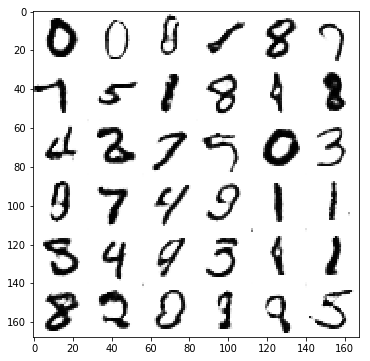

In [13]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={noise_input: z, is_training:False})
    # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
    g = (g + 1.) / 2.
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()